In [7]:
import os
import sys
import time

import pandas as pd
import numpy as np
from astropy.stats import mad_std
from astropy.stats import sigma_clip
from astropy.convolution import convolve, Box1DKernel

import scipy
from scipy import signal
from scipy import optimize
from scipy import stats
import scipy.fftpack
from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

from sklearn.preprocessing import MinMaxScaler

import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
# %matplotlib inline

### Defining some used mathematical functions

In [ ]:
exptime = 1765.3248
'''
Np = 204
N = len(data) // Np
N_mod = len(data) % Np
'''

def fft(flux, exptime=exptime):
    N1 = np.size(flux)
    w = scipy.fftpack.rfft(flux)
    freq_f = scipy.fftpack.rfftfreq(N1,exptime)
    spectrum = w**2
    return freq_f, spectrum


def ls(time, flux, P_min=0.1, P_max=1, space=10000):
    freq_ls = np.linspace(P_min, P_max, space)
    pgram = signal.lombscargle(time, flux, freq_ls, normalize=False)
    return freq_ls, pgram


def acf_value(flux, nlags):
    ts_acf = sm.tsa.stattools.acf(flux, nlags)
    return ts_acf


def phase_cut(df0, time, N, Np):
    dic = {}
    for i in range(N+1):
        if (Np*(i+1)+i < len(df0)):
            dic[i] = pd.DataFrame(df0[Np*i+i:Np*(i+1)+i+1])
        else:
            dic[i] = pd.DataFrame(df0[Np*i+i:len(data)])
        df = dic[i]
        df['PHASE']=(df['TIME']-df['TIME'][Np*i+i])/(time[Np]-time[0])
        #phase = df['PHASE']
        #flux = df['flux_n-slope']
    fname = []
    for i in range(N+1):
        fname.append(dic[i])
    comb_data = pd.concat(fname)
    #Sort the data with phase
    comb_data_s = comb_data.sort_values('PHASE')
    return comb_data_s


def rms(flux):
    return np.sqrt((flux**2).sum()/flux.size)


def rms_mag_model(flux, flux_model):
    residuals = -2.5 * np.log10(flux/flux_model)
    return np.sqrt(np.mean((residuals)**2)) 


def boxcar(phase, flux, comb_data_s, width=25):
    box = Box1DKernel(width)
    sm_signal = convolve(flux, box, boundary='extend')
    comb_data_s['boxcar'] = sm_signal
    return sm_signal


def binning(df0, phase, bc_model, N, N_mod, bins):
    #flux model bin
    bin_means, bin_edges, binnumber = stats.binned_statistic(phase, bc_model,
                                                             statistic='median', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_means
'''
#add binning data to dataframe
bc_model = pd.Series(bin_means,'model')
bc_model_rest = pd.Series(bin_means[:N_mod],'model')
sm = {}
for i in range(N):
    sm[i] = bc_model
bc_model_comb = pd.concat(sm,ignore_index=True)
bc_model_comb1 = pd.concat([bc_model_comb,bc_model_rest],ignore_index=True)
df_after = pd.concat([df0,bc_model_comb1],axis=1)
'''


In [59]:
class lightcurve:
    '''
    Light curve class.
    
    '''
    
    def __init__(self, filename='', time_col_label='', data_col_label='', verbose=False,
                 plot_preview=True, previewfig_name='preview.pdf',
                 xlim = [], ylim = [] 
                ):
        '''
        Initializer.
        
        Keywords:
        
        filename               [str]:  name of the input CSV file.
        
        time_col_label         [str]:  Time column name of the input CSV table.
        
        data_col_label         [str]:  Data column name of the input CSV table.
        
        plot_preview    [True/False]:  Generate preview figure if true.
        
        previewfig_name        [str] : Name of the output preview figure.
        
        xlim, ylim  [list of float] : X and y ranges for plotting 
        
        '''
        
        self.verbose = verbose
        
        self.meantimestep   = 0.0
        self.mintimestep    = 0.0
        self.maxtimestep    = 0.0
        self.stddevtimestep = 0.0
        self.mintime        = 0.0
        self.maxtime        = 0.0
        
        self.period         = []
        
        try:
            intable = pd.read_csv(filename)
            self.time    = intable[time_col_label]
            self.data    = intable[data_col_label]
            self.mintime = np.min(self.time)
            self.maxtime = np.max(self.time)
            
            self.time_plot = self.time
            self.data_plot = self.data
            self.x_label   = time_col_label
            self.y_label   = data_col_label
            
        except:
            if (verbose == True):
                print("Warning. Failed to open input file. Quit")
                
        if (plot_preview==True):
            self.plotdata(previewfig_name, label="Input data", xlim=xlim, ylim=ylim)
            
        self.get_timestep()
       
    
    def __del__(self):
        pass
    
    
    
    
    ##### Functions #######################################################
    def plotdata(self, outfigname, label='None', xlim=[], ylim=[]):
        '''
        Function to plot data as figure.
        
        Keyword:
        
        outfigname      [str]       : Name of the output figure.
        
        xlim, ylim  [list of float] : X and y ranges for plotting 
        
        '''
        fig = plt.figure(figsize=[10,6])
        ax = fig.add_axes([0.1, 0.1, 0.85, 0.85])
        
        ax.plot(self.time_plot, self.data_plot, 'o',  markersize=2, color=(0.2,0.2,0.2,1) )
        plt.tick_params(labelsize=14)
        plt.xlabel(self.x_label, fontsize=14)
        plt.ylabel(self.y_label, fontsize=14)  
        
        if (label != 'None'):
            ax.text(0.02, 0.92, label, transform=ax.transAxes, 
                     color=(0,0,0,1),
                     fontsize=14, horizontalalignment='left')
            
        if ( len(xlim) > 1 ):
            plt.xlim(xlim[0], xlim[1])
            
        if ( len(ylim) > 1 ):
            plt.ylim(ylim[0], ylim[1])        
        
        plt.show()
        plt.savefig(outfigname)        
    
    
    
    def fft(self, verbose=False, 
            plot_preview=False, previewfig_name='preview_fft.pdf',
            xlim=[], ylim=[]
           ):
        '''
        Doing FFT and return the frequency and power-spectrum of the data
        
        plot_preview    [True/False] :  Generate preview figure if true.
        
        previewfig_name        [str] :  Name of the output preview figure.
        
        xlim, ylim  [list of float]  : X and y ranges for plotting 
        '''
        
        # obtaining power-spectrum
        w = scipy.fftpack.rfft(self.data)
        spectrum = abs(w)**2
        
        # obtaining frequency
        freq = scipy.fftpack.rfftfreq( np.size(self.time), self.meantimestep)
        
        if (plot_preview==True):
            self.time_plot = freq
            self.data_plot = spectrum
            self.x_label   = 'Frequency'
            self.y_label   = 'Power'
            self.plotdata(previewfig_name, label='FFT', xlim=xlim, ylim=ylim)
        
        return freq, spectrum    
    
    
    
    ##### Methods #########################################################
    def get_timestep(self):
        '''
        Need to obtain the following information:
        The minimum time stamp, the maximum time stamp,
        the mean, minimum, and maximum time stemps.
        
        It will also update the information of timestep accordingly.
        '''
        
        timestep_list = []
        for i in range(0, len(self.time)-1 ):
            timestep_list.append( self.time[i+1] - self.time[i] )
        self.meantimestep   = np.mean(timestep_list)
        self.mintimestep    = np.min(timestep_list)
        self.maxtimestep    = np.max(timestep_list)
        self.stddevtimestep = np.std(timestep_list)
        
        if (self.verbose==True):
            if ( len( set(timestep_list) ) > 1 ):
                print( "Warning. Time step is not uniform. \n")
                print( "Identified time steps : ", set(timestep_list), "\n" )
       
    
    
    def interpolate(self, time_grid = np.array([]), 
                    plot_preview=False, previewfig_name='preview_interpolate.pdf',
                    xlim = [], ylim = []
                   ):
        '''
        Remove NaN from the data array and then interpolate the data onto the regular
        time grids as specified by input.
        
        
        Keywords:
        
        time_grid      [numpy array] :  Time grid to interpolate data onto.
                                        In the same unit with the input time.
        
        plot_preview    [True/False] :  Generate preview figure if true.
        
        previewfig_name        [str] :  Name of the output preview figure.
        
        xlim, ylim  [list of float]  : X and y ranges for plotting 
        
        '''
        
        if ( np.size(time_grid) > 0 ):
            
            # removing NaNs
            self.time = self.time[np.isfinite(self.data)]
            self.data = self.data[np.isfinite(self.data)]
            
            # interpolation
            self.data = np.interp(time_grid, self.time, self.data)
            self.time = time_grid
            timestep  = abs( time_grid[1] - time_grid[0] )
            self.meantimestep = timestep
            self.mintimeste   = timestep
            self.maxtimestep  = timestep
        
        if (plot_preview==True):
            self.time_plot = self.time
            self.data_plot = self.data
            self.plotdata(previewfig_name, label='Interpolated', xlim=xlim, ylim=ylim)
            
       
    
    def get_period(self, method='fft'):
        '''
        
        Evaluating the period assuming that the source has periodic variation.
        
        Keywords:
        
        method           [str]  : Methods to derive period.
            fft:  Using FFT to find periods from the input data.
                  The derived periods are sorted according to the strength of power spectrum.
                  
        '''
        
        if (method == 'fft'):
            
            freq, spectrum = self.fft()
            self.period =  1.0 / freq[ np.argmax(spectrum) ]
            
            if (self.verbose==True):
                print('Found periods derived using FFT : ',  self.period)
            


    
    
    

Warning. Time step is not uniform. 

Identified time steps :  {0.01999999999998181, 0.020000000000436557, 0.03000000000020009, 0.02999999999974534} 

Found periods derived using FFT :  4.090877192978735


/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


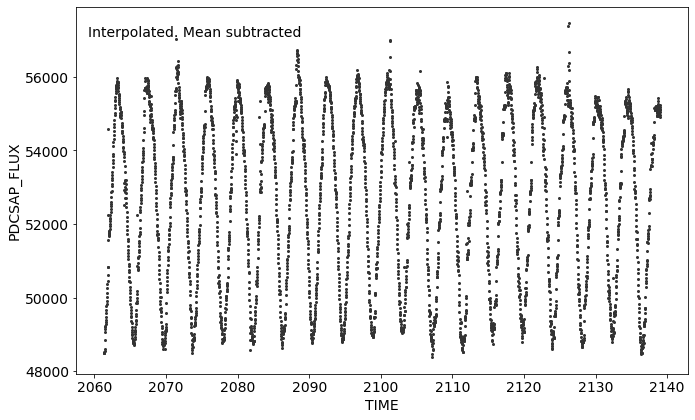

In [62]:
# Load data and plot a preview
testdata = lightcurve(filename = 'EPIC203318214_1.csv',
                      time_col_label='TIME',
                      data_col_label='PDCSAP_FLUX',
                      plot_preview=False,
                      previewfig_name='testdata_preview.pdf',
                      verbose=True
                     )

# interpolating data on regular time grid
time_grid = np.arange(testdata.mintime, testdata.maxtime,  testdata.mintimestep/3.0)
testdata.interpolate(time_grid = time_grid,
                     plot_preview=False,
                     previewfig_name='testdata_preview_interpolate.pdf'
                    )

# subtract mean value from the data
testdata.data = testdata.data - np.mean(testdata.data)
testdata.plotdata('testdata_preview_interpolate_meansubtracted.pdf', 
                 label='Interpolated. Mean subtracted')

# Testing fft
# testdata.fft(plot_preview=True, previewfig_name='testdata_preview_FFT.pdf', xlim=[0.0,1.0])

# Obtaining the period using the FFT method
testdata.get_period(method='fft')

### Import data

In [ ]:
data = pd.read_csv('EPIC203318214_1.csv')

time = data['TIME']
f_n = data['flux_n']
f_n_m = data['flux_n-median']

fig=plt.figure()
plt.plot(time, f_n,  markersize=4)
plt.tick_params(labelsize=10)
#plt.ylim(0.9,1.1)
              
plt.xlabel(time.name)
plt.ylabel(f_n.name)
              
plt.show()

### FFT

In [ ]:
freq_fft, power_fft = fft(f_n_m)
plt.plot(freq_fft, power_fft)
plt.xlim(0,5e-6)
plt.ylim(0,2.5e5)

In [ ]:
p_fft = freq_fft[power_fft>1.5e5]
print(1/p_fft/60**2/24)

In [ ]:
#lomb scargle
freq_ls, power_ls = ls(time, f_n_m)
plt.plot(freq_ls, power_ls)

### ACF

In [ ]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax1.set_yticks(np.linspace(-1,1,10))
fig = sm.graphics.tsa.plot_acf(f_n, lags=3804, ax=ax1)
#ax2 = fig.add_subplot(212)
#fig = sm.graphics.tsa.plot_pacf(flux, lags=1500, ax=ax2)

In [ ]:
acf_values = sm.tsa.stattools.acf(f_n,nlags=3804)
acf_values[200:210]
#204 has largest value

In [ ]:
print(204*exptime/60/60/24,time[204]-time[0])

### Folding data

In [ ]:
# Define the values to fold the data
Np = 204
N = len(data) // Np
N_mod = len(data) % Np

In [ ]:
split_data = phase_cut(data, time, N, Np)
phase = split_data['PHASE']
f_n_sp = split_data['flux_n']
f_n_m_sp = split_data['flux_n-median']
#split_data

In [ ]:
#boxcar-smoothing (folding data)
#normarize flux version
bc_lc = boxcar(phase, f_n_sp, split_data)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(phase, f_n_sp, s=5)
plt.plot(phase, bc_lc, c='black')
plt.scatter(phase, f_n_sp - bc_lc - 0.4, s=4)
plt.ylim(-0.7,1.1)

#normarize flux - median version
bc_lc_m = boxcar(phase, f_n_m_sp, split_data)
plt.subplot(122)
plt.scatter(phase, f_n_m_sp, s=5)
plt.plot(phase, bc_lc_m, c='black')
plt.scatter(phase, f_n_m_sp - bc_lc_m - 1, s=4)
plt.ylim(-1.3,0.6)

In [ ]:
#binning the boxcar-smoothing LC
bins = np.linspace(0, 1, Np+1)
#normarize flux version
 #binning
bin_mean = binning(data, phase, bc_lc , N, N_mod, bins)
 #combine data
bc_model = pd.Series(bin_mean,name='model')
bc_model_rest = pd.Series(bin_mean[:N_mod],name='model')
sm = {}
for i in range(N):
    sm[i] = bc_model
    bc_model_comb = pd.concat(sm,ignore_index=True)
    bc_model_comb1 = pd.concat([bc_model_comb,bc_model_rest],ignore_index=True)
    data_after0 = pd.concat([data,bc_model_comb1],axis=1)


#normarize flux - median version
 #binning
bin_mean_m = binning(data, phase, bc_lc_m , N, N_mod, bins)
 #combine data
bc_model_m = pd.Series(bin_mean_m, name='model_m')
bc_model_rest_m = pd.Series(bin_mean_m[:N_mod],name='model_m')
sm_m = {}
for i in range(N):
    sm_m[i] = bc_model_m
    bc_model_comb_m = pd.concat(sm_m,ignore_index=True)
    bc_model_comb1_m = pd.concat([bc_model_comb_m,bc_model_rest_m],ignore_index=True)
    data_after = pd.concat([data_after0,bc_model_comb1_m],axis=1)



time = data_after['TIME']
f_n = data_after['flux_n']
f_n_m = data_after['flux_n-median']
bc_model = data_after['model']
bc_model_m = data_after['model_m']
resid = f_n - bc_model
resid_m = f_n_m - bc_model_m

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(time, f_n, s=4)
plt.plot(time, bc_model, c='black')
plt.scatter(time, resid - 0.5, s=4)
plt.ylim(-0.8, 1.1)

plt.subplot(122)
plt.scatter(time, f_n_m, s=4)
plt.plot(time, bc_model_m, c='black')
plt.scatter(time, resid_m - 1, s=4)
plt.ylim(-1.3, 0.6)

### Calculate the Q value
$$Q = \frac{(rms_{resid}^2 - \sigma^2)}{(rms_{raw}^2 - \sigma^2)}$$

$rms_{resid}$ : the rms values of the phase-subtracted light curve   
$rms_{raw}$ : the rms values of the raw light curve   
$\sigma$ : the estimated uncertainty including the systematics

this target (Cody2018) : Q = 0.03

In [ ]:
rms_raw = rms(f_n)
rms_resid = rms(resid)

rms_raw_m = rms(f_n_m)
rms_resid_m =rms(resid_m)

Q_value = rms_resid**2/rms_raw**2
Q_value_m = rms_resid_m**2/rms_raw_m**2
print(rms_raw, rms_resid,Q_value)
print(rms_raw_m, rms_resid_m, Q_value_m)

### comment : rms(normarized flux - median) is incorrect because the flux have minus values

## M value

$$
    M = \frac{(<d_{10\%}>-d_{med})}{\sigma_d}
$$
 
$d_{10\%}$ : the mean of all data at the top and bottom decile of light curve    
$d_{med}$ : the median of the entire light curve   
$\sigma_d$ : its overall rms  

this target (Cody2018) : M = 0.19

In [ ]:
#boxcar smoothing (time-series data)
bc_flux = boxcar(time, f_n, data_after)
data_after['resid'] = f_n - bc_flux
resid_all = data_after['resid']

plt.scatter(time, f_n, s=5)
plt.plot(time, bc_flux, c='black')
plt.scatter(time, f_n - bc_flux - 0.5 , s=4)
plt.ylim

In [ ]:
data_no_outlier = pd.DataFrame()
clip = sigma_clip(resid_all,sigma=5)
 
try:
    #just in case there is any outlier try the following:
        
    #identify the index of that outlier
    idx = resid_all[clip.mask].index.values
        
    #using idx, drop/remove the entire row where the outlier is found
    data_no_outlier = data_after.drop(data_after.index[idx], axis=0)
    
except:
    #if there is no outlier, just pass or do nothing 
    pass

In [ ]:
df_sort = data_no_outlier.sort_values('flux_n')
df_sort1 = df_sort.reset_index()
flux_raw_split = df_sort1['flux_n']

#the mean of all data at the top and bottom decile of light curve
flux_devide = len(df_sort1)//10
flux_min = flux_raw_split[:379]
flux_max = flux_raw_split[-379:]
d_10 = (sum(flux_min) + sum(flux_max))/(len(flux_min) + len(flux_max))

#the median of the entire light curve
d_med = np.median(flux_raw_split)

sigma_d = rms(flux_raw_split)
M_value = (d_10-d_med)/sigma_d
print(d_10, d_med, M_value)

In [43]:
a = [1,2,3,4,5]
print( np.argsort(a) )

[0 1 2 3 4]
